In [1]:
using Distributions, Compat, Plots, Random

#3 (generic function with 1 method)

Kalman Filter Gleichungen

In [2]:
t = (m) -> transpose(m) # Sorthand for transpose
# Filtered state equations
x̂_F = (x̂, y, Σ, G, R) -> x̂ + Σ + t(G) * (G * Σ * t(G) + R)^-1 * (y - G * x̂)
Σ_F = (Σ, G, R) -> Σ - Σ * t(G) * (G * Σ * t(G) + R)^-1 * G * Σ

# Kalman Gain
K = (A, Σ, G, R) -> A * Σ * t(G) * (G * Σ * t(G) + R)^-1

# Predicted state equations
x̂_next = (A, x̂, K, y, G) -> A * x̂ + K * (y - G * x̂)
Σ_next = (A, Σ, K, G, Q) -> A * Σ * t(A) - K * G * Σ * t(A) + Q

mutable struct Kalman
    A # State transition
    Q # Process covariance matrix
    
    G # Measurement mapping
    R # Measurement covariance matrix
    
    x̂ # Current estimate mean
    Σ # Current estimate uncertianty
end

function fusion(k::Kalman, y)
    k.x̂ = x̂_F(k.x̂, y, k.Σ, k.G, k.R)
    k.Σ = Σ_F(k.Σ, k.G, k.R)
    Normal(k.x̂, k.Σ)
end

function predict(k::Kalman, y)
    gain = K(k.A, k.Σ, k.G, k.R)
    k.x̂ = x̂_next(k.A, k.x̂, gain, y, k.G)
    k.Σ = Σ_next(k.A, k.Σ, gain, k.G, k.Q)
    Normal(k.x̂, k.Σ)
end

predict (generic function with 1 method)

In [14]:
ρ = 10 # Die Spannung, die wir messen ist immer konstant
A = 1
Q = 0
R = 1
G = 1

x_0 = 8
Σ_0 = 1 
y = () -> G * ρ + rand(Normal(0, R)) # Messfunktion

model = Kalman(A, G, Q, R, x_0, Σ_0)

Kalman(1, 1, 0, 1, 8, 1)

In [8]:
p_0 = Normal(x_0, Σ_0) # Start period with p_t(x) = N(x̂_t, Σ_t)
y_0 = y() # Observe measurement y_t
# Compute filtering distribution p(x|y) = N(x̂_0_F, Σ_0_F)
x̂_F_0 = x̂_F(x_0, y_0, Σ_0, G, R)
Σ_F_0 = Σ_F(Σ_0, G, R)
p_0_x_y = Normal(x̂_F_0, Σ_F_0)
# Compute predictive distribution
K_0 = K(A, Σ_0, G, R) # The Kalman Gain
x̂_1 = x̂_next(A, x̂_F_0, K_0, y_0, G)
Σ_1 = Σ_next(A, Σ_0, K_0, G, Q)
p_1 = Normal(x̂_1, Σ_1)

y_1 = y() # Observe measurement in `t = 1`
x̂_F_1 = x̂_F(x̂_1, y_1, Σ_1, G, R) # Compute filtering distributions
Σ_F_1 = Σ_F(Σ_1, G, R)
# Compute predictive distribution
K_1 = K(A, Σ_1, G, R) # The Kalman Gain
x̂_2 = x̂_next(A, x̂_F_1, K_1, y_1, G)
Σ_2 = Σ_next(A, Σ_1, K_1, G, Q)
p_2 = Normal(x̂_2, Σ_2)

Normal{Float64}(μ=9.668598561791818, σ=0.33333333333333337)

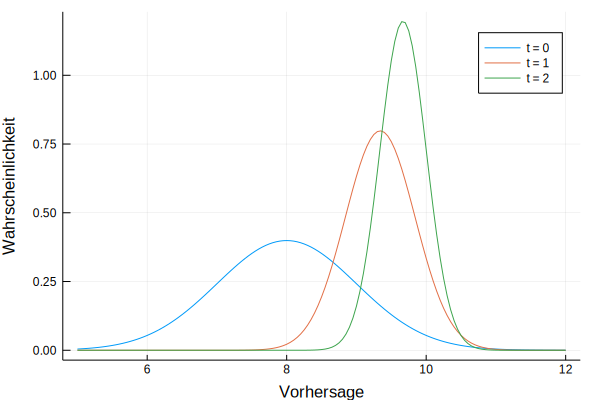

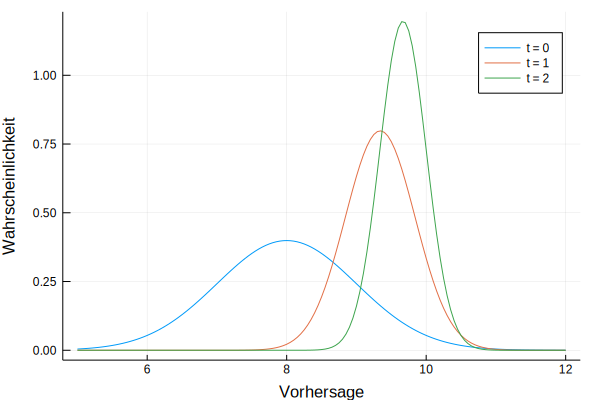

In [16]:
range = 5:0.05:12
plot(range, pdf.(p_0, range), label = "t = 0", xlabel = "Vorhersage", ylabel = "Wahrscheinlichkeit")
plot!(range, pdf.(p_1, range), label = "t = 1")
plot!(range, pdf.(p_2, range), label = "t = 2")

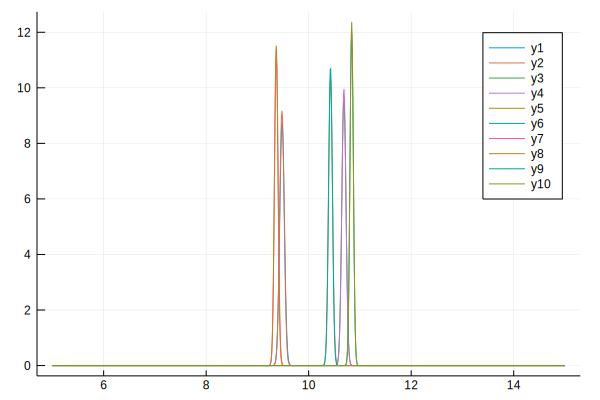

In [13]:
range = 5:0.01:15
default(show=:inline)
pl = plot()
for i = 1:5
    y_cur = y()
    x_1 = fusion(model, y_cur)
    plot!(range, pdf.(x_1, range))
    x_2 = predict(model, y_cur)
    plot!(range, pdf.(x_2, range))
end